<h1>1 <span style='color:#164cf0'>|</span> Import Libraries</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import keras
import math

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima import model
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm 

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

%matplotlib inline

<h1>2 <span style='color:#164cf0'>|</span> Load data and delete outliers</h1>

In [2]:
df = pd.read_csv('data\DailyDelhiClimate.csv')
#remove outliers from pressure
df.replace(to_replace = list(df.iloc[df['meanpressure'].argsort()[-3:]]['meanpressure']), value = df['meanpressure'].mean(), inplace = True)
df.replace(to_replace = list(df.iloc[df['meanpressure'].argsort()[:6]]['meanpressure']), value = df['meanpressure'].mean(), inplace = True)

df['t'] = [i for i in range(1,len(df['meantemp'])+1)]
df['month'] = [x.split('-')[1] for x in df['date']]

In [3]:
#divide the df into train and test
df_train = df.iloc[:1200]
df_test  = df.iloc[1200:]

<h1>3 <span style='color:#164cf0'>|</span> EDA</h1>

<strong><font size='4'>3.1 <span style='color:#164cf0'>|</span> Plot values</font></strong>

Text(0.5, 1.0, 'pressure')

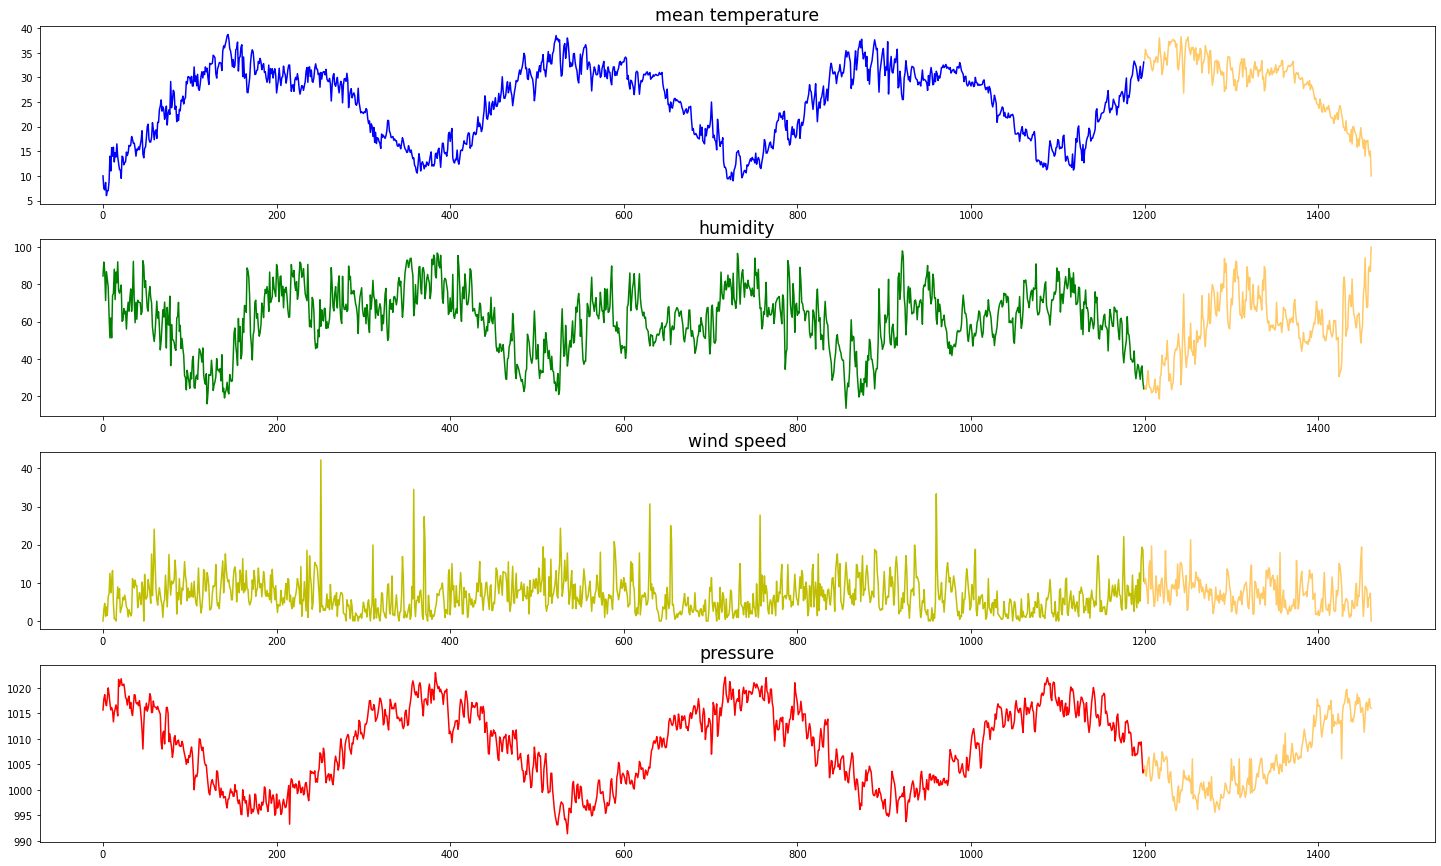

In [4]:
fig, axs = plt.subplots(4,1, figsize = (25,15), facecolor = 'white')

axs[0].plot(df_train['meantemp'], color = 'b')
axs[0].plot(df_test['meantemp'], color = 'orange', alpha = 0.6)
axs[0].set_title('mean temperature', fontsize = 'xx-large')

axs[1].plot(df_train['humidity'], color = 'g')
axs[1].plot(df_test['humidity'], color = 'orange', alpha = 0.6)
axs[1].set_title('humidity', fontsize = 'xx-large')

axs[2].plot(df_train['wind_speed'], color = 'y')
axs[2].plot(df_test['wind_speed'], color = 'orange', alpha = 0.6)
axs[2].set_title('wind speed', fontsize = 'xx-large')

axs[3].plot(df_train['meanpressure'], color = 'r')
axs[3].plot(df_test['meanpressure'], color = 'orange', alpha = 0.6)
axs[3].set_title('pressure', fontsize = 'xx-large')

<strong><font size='4'>3.2 <span style='color:#164cf0'>|</span> Correlation matrix</font></strong>

<AxesSubplot:>

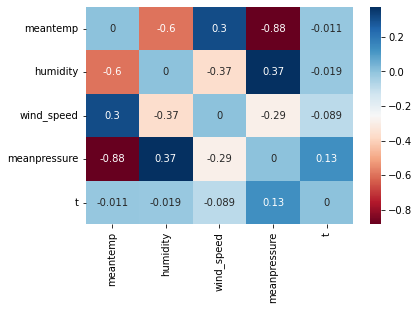

In [5]:
plt.figure(facecolor = 'white')
corr_mat = df_train.corr().replace(to_replace = 1.0, value = 0)
sns.heatmap(corr_mat, annot = True, cmap = 'RdBu')

---------------------

<h1>4 <span style='color:#164cf0'>|</span> additive model</h1>

<font size = '4'>this type of approach consider the time series as composed by 3 main components:</font>
- <font size ='4'><mark>trend</mark>: this part is just a function of the time</font>
- <font size ='4'><mark>seasonality</mark>: the value of the series depend on the season (period of the year)</font>
- <font size ='4'><mark>noise</mark>: this is the unpredictable part of the series</font>

<font size ='4'><center>$Y = T + S + \epsilon$</center></font>


<strong><font size='5'>4.1 <span style='color:#164cf0'>|</span> Trend</font></strong>

<font size="4">To extract the trend we simply do a linear regression on the historic series</font>

In [6]:
#add a constant to the model
t = sm.add_constant(df_train['t'])

model_ols = sm.OLS(df_train['meantemp'],t)
trend = model_ols.fit()

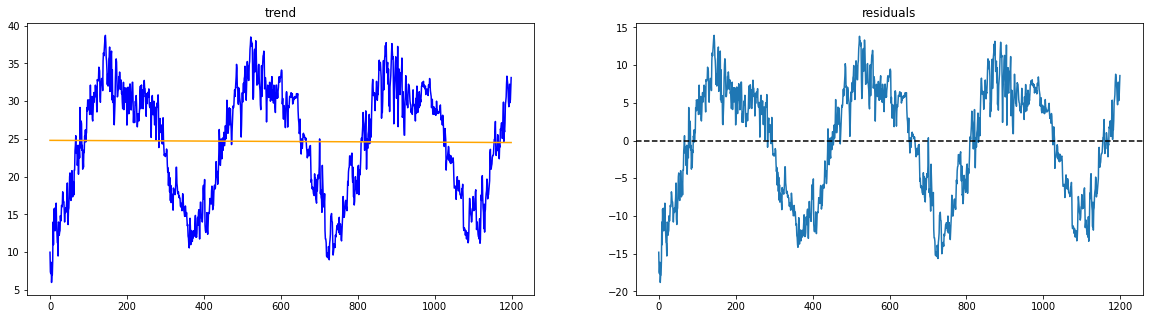

In [7]:
#plot the trend
plt.figure(figsize=(20,5), facecolor = 'white')

plt.subplot(1,2,1)
plt.plot(df_train['meantemp'], color = 'b')
plt.plot(trend.fittedvalues, color = 'orange')
plt.title('trend')

plt.subplot(1,2,2)
plt.plot(trend.resid)
plt.title('residuals')
plt.axhline(y = 0,color='black', ls = '--')

<font size='4'>as we can see once removed the trend the series oscillates around zero. now we have to remove the seasonality

<strong><font size='5'>4.2 <span style='color:#164cf0'>|</span> seasonality</font></strong>

In [8]:
encoder = OneHotEncoder(sparse = False)
encoded_monthes = encoder.fit_transform(np.array(df_train['month']).reshape(-1,1))

model_season = sm.OLS(trend.resid, encoded_monthes)
seasonality = model_season.fit()

Text(0.5, 1.0, 'residuals')

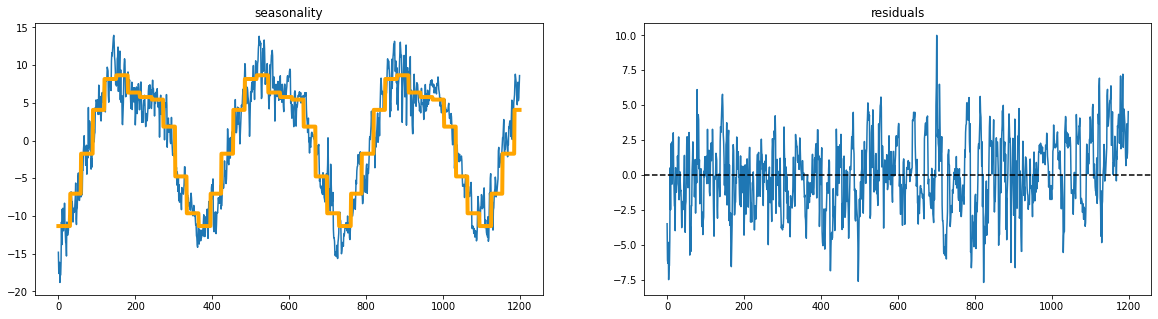

In [9]:
#plot the seasonality
plt.figure(figsize = (20,5), facecolor = 'white')

plt.subplot(1,2,1)
plt.plot(trend.resid)
plt.plot(seasonality.fittedvalues, color = 'orange', linewidth = 4)
plt.title('seasonality')

plt.subplot(1,2,2)
plt.plot(seasonality.resid)
plt.axhline(y = 0, color = 'black', ls = '--')
plt.title('residuals')

<strong><font size='5'>4.3 <span style='color:#164cf0'>|</span> Residuals analisys</font></strong>

<font size='4'>now we analyse the residuals to be sure that no information is contained in them</font>

Text(0.5, 1.0, 'PACF')

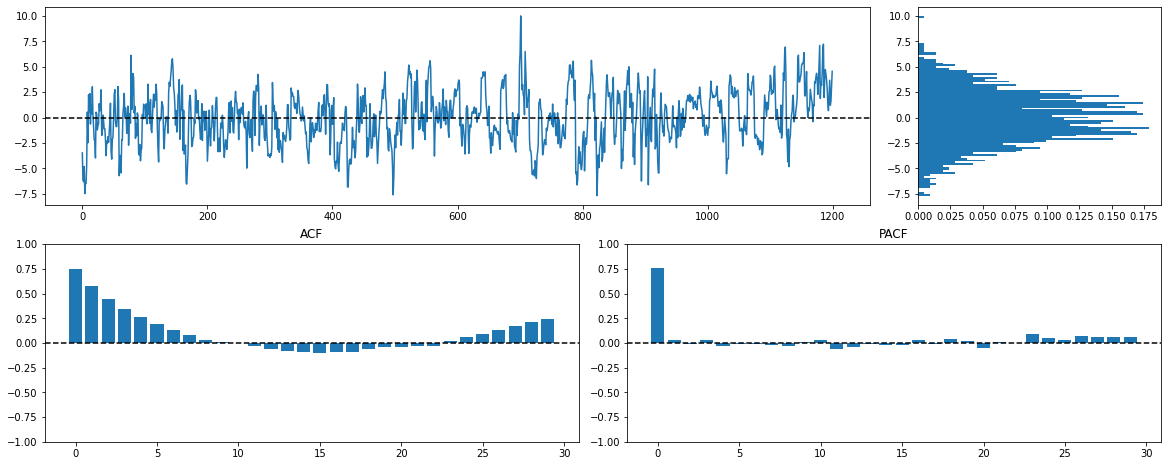

In [10]:
plt.figure(figsize=(20,8), facecolor = 'white')

#Residuals
plt.subplot(2,4,(1,3))
plt.plot(seasonality.resid)
plt.axhline(y = 0, color = 'black', ls = '--', linewidth = 1.5)

plt.subplot(2,4,4)
plt.hist(seasonality.resid, orientation = 'horizontal', density = True, bins = 100)

#ACF
acf_resid = acf(seasonality.resid)[1:]
plt.subplot(2,4,(5,6))
plt.ylim(-1,1)
plt.bar(x = range(len(acf_resid)),height = acf_resid)
plt.axhline(y = 0, color = 'black', ls = '--', linewidth = 1.5)
plt.title('ACF')

#PACF
pacf_resid = pacf(seasonality.resid)[1:]
plt.subplot(2,4,(7,8))
plt.ylim(-1,1)
plt.bar(x = range(len(pacf_resid)), height = pacf_resid)
plt.axhline(y = 0, color = 'black', ls = '--', linewidth = 1.5)
plt.title('PACF')

<strong><font size='5'>4.4 <span style='color:#164cf0'>|</span> inference on the auto-correlation of the residuals</font></strong>

<font size='4'>under the null hipothesys the process $\left \{  X_{t}\right \}$ is not autocorrelated and for an hight $n$ we know that:</font>
<font size='4'><center>$\rho_{k} \sim N(0,\frac{1}{n})$</center></font>
<font size='4'> that means that the confidence intervall will be:</font>
<center><font size='4'>$\left [ -\frac{1}{\sqrt{n}}\cdot z_{\alpha/2} , \frac{1}{\sqrt{n}}\cdot z_{\alpha/2}\right ]$</font></center>


Text(0.5, 1.0, 'PACF')

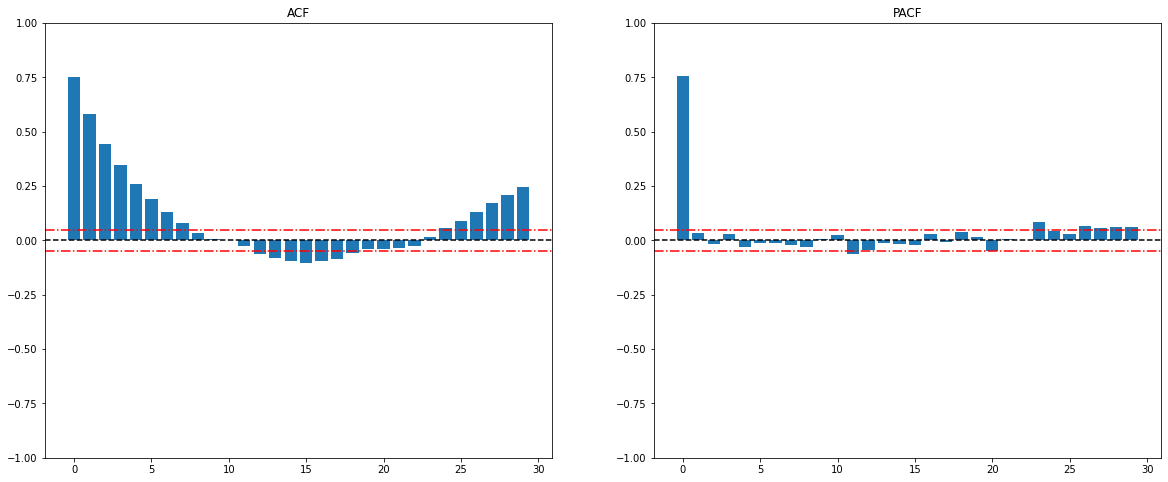

In [11]:
plt.figure(figsize=(20,8), facecolor = 'white')
n = len(seasonality.resid)
alpha = 0.05
z_alpha = abs(norm.ppf(0.05))
h_alpha = (1/math.sqrt(n)) * z_alpha

#ACF
acf_resid = acf(seasonality.resid)[1:]
plt.subplot(1,2,1)
plt.ylim(-1,1)
plt.bar(x = range(len(acf_resid)),height = acf_resid)
plt.axhline(y = 0, color = 'black', ls = '--', linewidth = 1.5)
plt.axhline(y = h_alpha, color = 'red', ls = 'dashdot', linewidth = 1.5)
plt.axhline(y = -h_alpha, color = 'red', ls = 'dashdot', linewidth = 1.5)
plt.title('ACF')

#PACF
pacf_resid = pacf(seasonality.resid)[1:]
plt.subplot(1,2,2)
plt.ylim(-1,1)
plt.bar(x = range(len(pacf_resid)), height = pacf_resid)
plt.axhline(y = 0, color = 'black', ls = '--', linewidth = 1.5)
plt.axhline(y = h_alpha, color = 'red', ls = 'dashdot', linewidth = 1.5)
plt.axhline(y = -h_alpha, color = 'red', ls = 'dashdot', linewidth = 1.5)
plt.title('PACF')

<font size='4'>as we can see there is a lot of information in the residuals, looking at the ACF and PACF plots probably the best model to capture this information is an <mark>ARMA(1,0)</mark> <font>

<h1>5 <span style='color:#164cf0'>|</span> ARMA model on the residuals</h1>

In [12]:
arima_mod = model.ARIMA(seasonality.resid, order = (1,0,0))
arima_fit = arima_mod.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1200
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2345.021
Date:                Sun, 10 Jul 2022   AIC                           4696.041
Time:                        19:12:19   BIC                           4711.312
Sample:                             0   HQIC                          4701.794
                               - 1200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.206      0.013      0.989      -0.402       0.407
ar.L1          0.7555      0.019     40.118      0.000       0.719       0.792
sigma2         2.9148      0.090     32.426      0.0

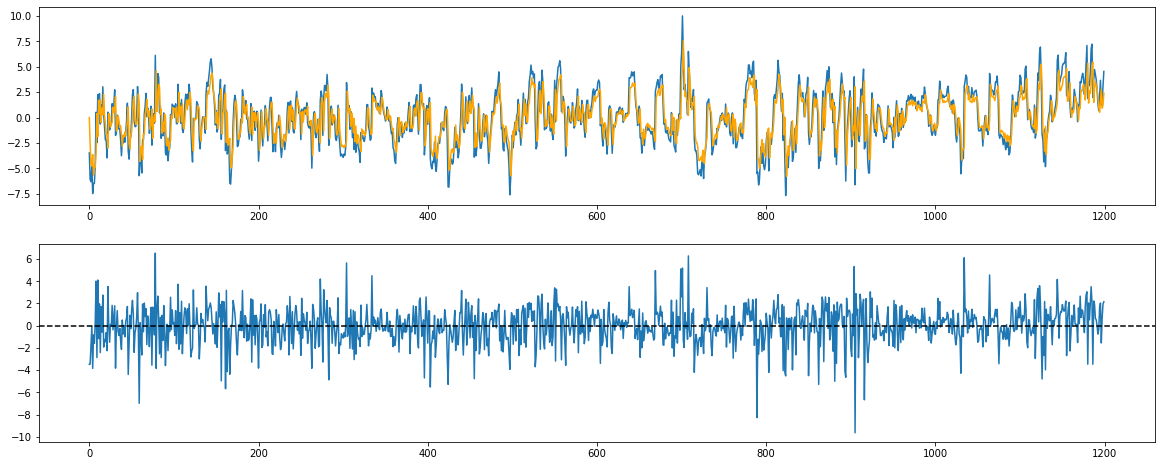

In [13]:
#plot the result of the ARMA(1,0)
plt.figure(figsize = (20,8), facecolor = 'white')
plt.subplot(2,1,1)
plt.plot(seasonality.resid)
plt.plot(arima_fit.fittedvalues, color = 'orange')

plt.subplot(2,1,2)
plt.plot(arima_fit.resid)
plt.axhline(y = 0, color = 'black', ls = '--')

Text(0.5, 1.0, 'PACF')

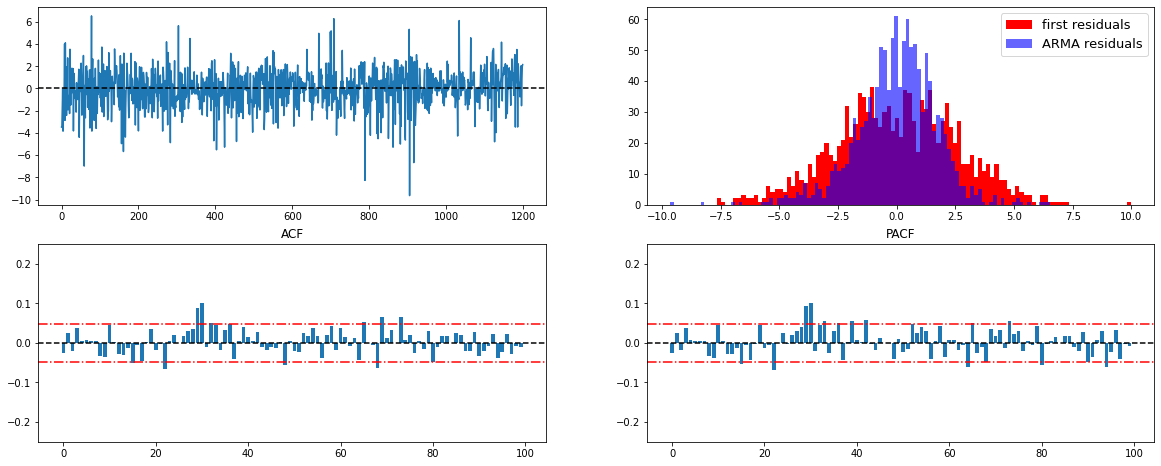

In [14]:
plt.figure(figsize=(20,8), facecolor = 'white')

#Residuals
plt.subplot(2,2,1)
plt.plot(arima_fit.resid)
plt.axhline(y = 0, color = 'black', ls = '--', linewidth = 1.5)

plt.subplot(2,2,2)
plt.hist(seasonality.resid, bins = 100, color = 'red', label = 'first residuals')
plt.hist(arima_fit.resid, bins=100, color = 'blue', label = 'ARMA residuals', alpha = 0.6)
plt.legend(prop={'size': 13})

#confidence intervall
n = len(arima_fit.resid)
alpha = 0.05
z_alpha = abs(norm.ppf(0.05))
h_alpha = (1/math.sqrt(n)) * z_alpha

#ACF
acf_resid = acf(arima_fit.resid, nlags = 100)[1:]
plt.subplot(2,2,3)
plt.ylim(-0.25,0.25)
plt.bar(x = range(len(acf_resid)),height = acf_resid)
plt.axhline(y = 0, color = 'black', ls = '--', linewidth = 1.5)
plt.axhline(y = h_alpha, color = 'red', ls = 'dashdot', linewidth = 1.5)
plt.axhline(y = -h_alpha, color = 'red', ls = 'dashdot', linewidth = 1.5)
plt.title('ACF')

#PACF
pacf_resid = pacf(arima_fit.resid, nlags = 100)[1:]
plt.subplot(2,2,4)
plt.ylim(-0.25,0.25)
plt.bar(x = range(len(pacf_resid)), height = pacf_resid)
plt.axhline(y = 0, color = 'black', ls = '--', linewidth = 1.5)
plt.axhline(y = h_alpha, color = 'red', ls = 'dashdot', linewidth = 1.5)
plt.axhline(y = -h_alpha, color = 'red', ls = 'dashdot', linewidth = 1.5)
plt.title('PACF')

In [15]:
print(f'var residuals before ARIMA = {np.var(seasonality.resid)}')
print(f'var residuals after ARIMA = {np.var(arima_fit.resid)}')

var residuals before ARIMA = 6.769976542774134
var residuals after ARIMA = 2.920501683868219


<font size = '4'>as we can see thank to the ARMA model we reduced the variance of the residuals by a lot, from 6.76 down to 2.92 and as we can see from the ACF and PACF we have 5/6 significative lags correlations but probably this is due to 0.05 alpha</font>

<strong><font size='5'>5.1 <span style='color:#164cf0'>|</span> portmanteau test</font></strong>

<font size='4'>this test aim to verify the presence of correlation among a model residuals, the test has the following structure:</font>
<font size='4'><center>$ \left\{\begin{matrix}
H_{0} : \rho_{1} = ... = \rho{k} = 0 \\
H_{1} : \rho_{j} \neq 0 \textrm{   , for at least one j } \in \left \{ 1...k \right \}
\end{matrix}\right.$</center></font>
<font size='4'>the test statistics is:</font>
<font size='4'><center>$ Q(k) = n(n+2)\sum_{k = 1}^{K}\frac{\hat{\rho_{k}}^2}{n-k}$</center></font>

In [16]:
acorr_ljungbox(arima_fit.resid, lags = [30])

,lb_stat,lb_pvalue
30,37.779556,0.155492


<font size='4'>as we can see the p_value is higher then 0.05 so we will accept $H_{0}$ that is, there are no correlation left in the residuals

<strong><h1>6 <span style='color:#164cf0'>|</span> Test the model</h1></strong>

<font size='4'>now we have e different models that works on 3 different components of the series:</font>
- <font size='4'>trend: for the trend part</font>
- <font size='4'>seasonality: for the seasonality</font>
- <font size='4'>arima_fit: for the residuals</font>

In [17]:
#trend prediction
t_test = sm.add_constant(df_test['t'])

trend_preds = []

for v in zip(t_test['const'],t_test['t']):
        trend_preds.append(trend.predict(v))

In [18]:
# seasonality prediction
encoded_monthes_test = encoder.transform(np.array(df_test['month']).reshape(-1,1))

seasonality_preds = []

for i in encoded_monthes_test:
    seasonality_preds.append(seasonality.predict(i))

#calculate residuals from trend + seasonality
trend_season_pred = np.array(trend_preds).ravel() + np.array(seasonality_preds).ravel()
resid = np.array(df_test['meantemp'][1:]) - np.array(trend_season_pred[:-1])

#ARIMA on the residuals
arima_predictions = arima_fit.predict(start=resid.shape[0],end=(resid.shape[0]+resid.shape[0]-1), dynamic=False)

final_preds = trend_season_pred[1:] + np.array(arima_predictions).ravel() 

<strong><font size='5'>6.1 <span style='color:#164cf0'>|</span> Plot the results</font></strong>

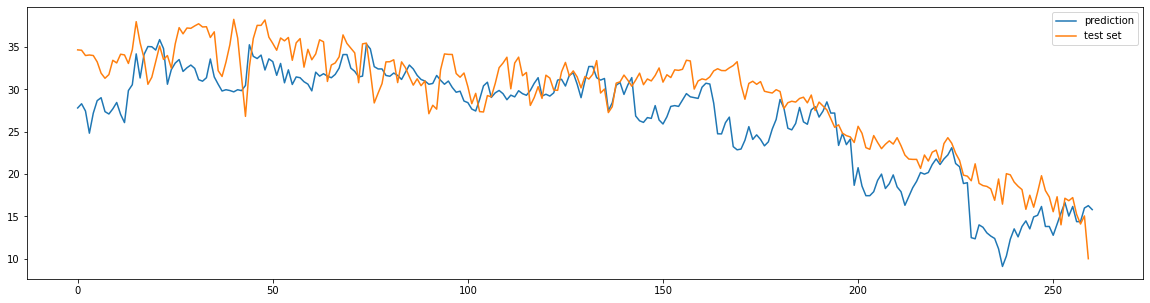

In [19]:
plt.figure(figsize = (20,5), facecolor = 'white')

plt.plot(final_preds, label = 'prediction')
plt.plot(list(df_test['meantemp'][2:]), label = 'test set')
plt.legend()

---------------------

<h1>🔁 <span style='color:#164cf0'>|</span> RNN</h1>

<strong><font size='5'>1 <span style='color:#164cf0'>|</span> Data preparation</font></strong>

In [20]:
def scale_df (df_full : pd.DataFrame , sub_df : list, features : list):
    
    scaler = StandardScaler()

    for f in features:
        scaler.fit(np.array(df_full[f]).reshape(-1,1))
        for df in sub_df:
            df[f] = scaler.transform(np.array(df[f]).reshape(-1,1))

In [21]:
scale_df(df_full = df, sub_df = [df_train, df_test], features = ['meantemp', 'humidity', 'meanpressure', 'wind_speed'])

C:\Users\bolla\AppData\Local\Temp\ipykernel_19532\1319882079.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f] = scaler.transform(np.array(df[f]).reshape(-1,1))
C:\Users\bolla\AppData\Local\Temp\ipykernel_19532\1319882079.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f] = scaler.transform(np.array(df[f]).reshape(-1,1))
C:\Users\bolla\AppData\Local\Temp\ipykernel_19532\1319882079.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [22]:
X_train = np.array(df_train.loc[:,['wind_speed','humidity', 'meanpressure']])
Y_train = np.array(df_train.loc[:,['meantemp']])

X_test = np.array(df_test.loc[:,['wind_speed','humidity', 'meanpressure']])[:150]
Y_test = np.array(df_test.loc[:,['meantemp']])[:150]

X_val = np.array(df_test.loc[:,['wind_speed','humidity', 'meanpressure']])[150:]
Y_val = np.array(df_test.loc[:,['meantemp']])[150:]

In [23]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

<strong><font size='5'>1.1 <span style='color:#164cf0'>|</span> Model</font></strong>

In [24]:
model = keras.Sequential()

model.add(keras.layers.LSTM(64, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(units=1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [26]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath = '../RNN.hdf5',monitor="val_loss",verbose=1,save_best_only=True)]
history = model.fit(X_train,Y_train, validation_data=(X_val,Y_val),epochs=100, verbose = 1, callbacks = callbacks)

Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 0.7784 
Epoch 1: val_loss improved from inf to 0.44456, saving model to ..\RNN.hdf5
38/38 [==============================] - 2s 17ms/step - loss: 0.7810 - val_loss: 0.4446
Epoch 2/100
36/38 [===========================>..] - ETA: 0s - loss: 0.4771
Epoch 2: val_loss improved from 0.44456 to 0.35554, saving model to ..\RNN.hdf5
38/38 [==============================] - 0s 4ms/step - loss: 0.4685 - val_loss: 0.3555
Epoch 3/100
23/38 [=================>............] - ETA: 0s - loss: 0.3110
Epoch 3: val_loss improved from 0.35554 to 0.29468, saving model to ..\RNN.hdf5
38/38 [==============================] - 0s 4ms/step - loss: 0.2757 - val_loss: 0.2947
Epoch 4/100
23/38 [=================>............] - ETA: 0s - loss: 0.1859
Epoch 4: val_loss improved from 0.29468 to 0.23720, saving model to ..\RNN.hdf5
38/38 [==============================] - 0s 3ms/step - loss: 0.1753 - val_loss: 0.2372
Epoch 5/100
25/38 [===========

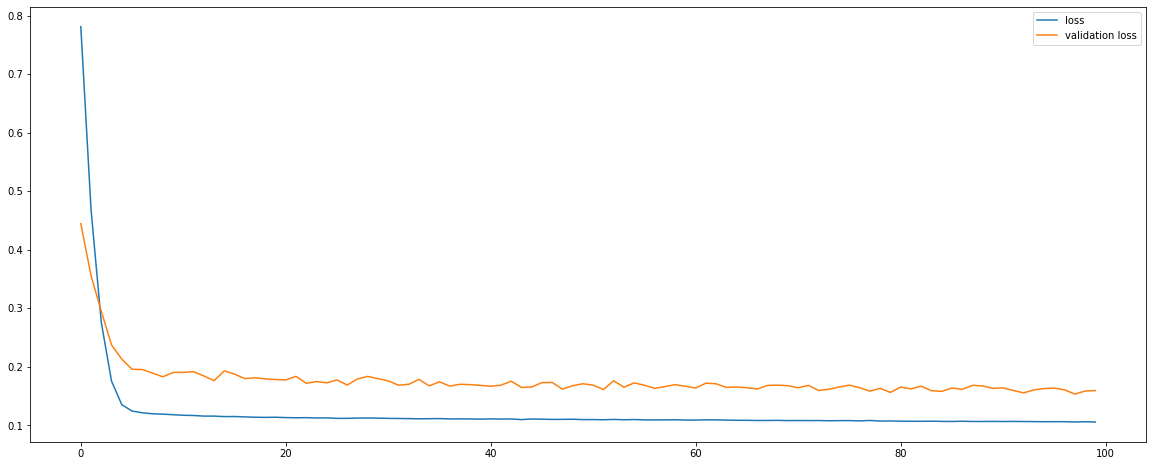

In [27]:
plt.figure(figsize = (20,8), facecolor = 'white')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

<strong><font size='5'>1 <span style='color:#164cf0'>|</span> Prediction on test set</font></strong>

In [28]:
predictions_rnn = model.predict(X_test)

5/5 [==============================] - 0s 2ms/step


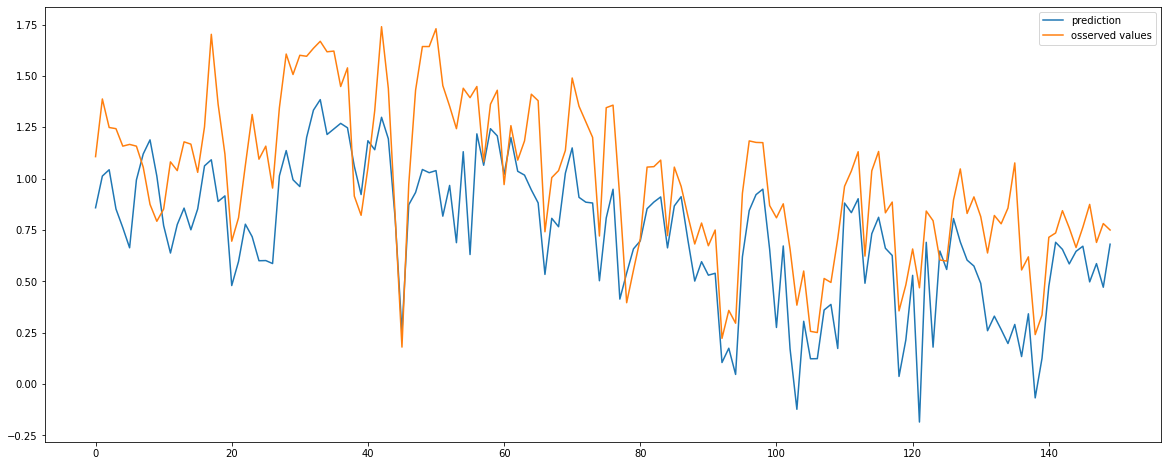

In [29]:
plt.figure(figsize = (20,8), facecolor = 'white')
plt.plot(predictions_rnn, label = 'prediction')
plt.plot(Y_test, label = 'osserved values')
plt.legend()

Text(0.5, 1.0, 'residuals distribution')

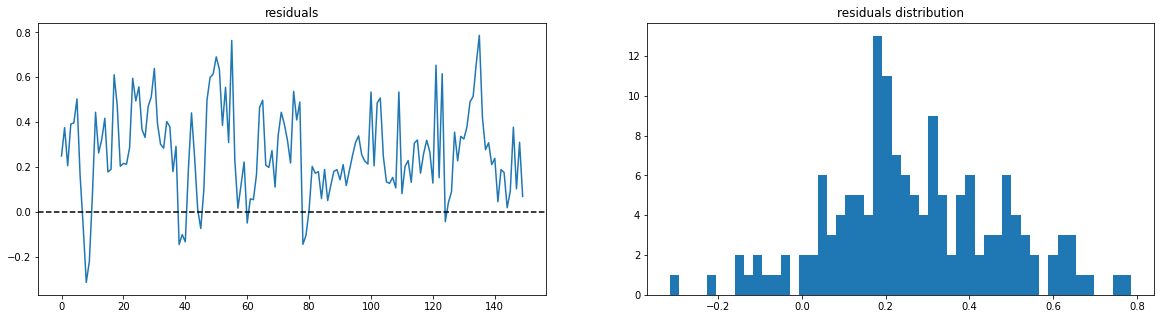

In [30]:
residuals_rnn = np.array(Y_test).ravel() - np.array(predictions_rnn).ravel()
plt.figure(figsize=(20,5), facecolor = 'white')
plt.subplot(1,2,1)
plt.plot(residuals_rnn)
plt.title('residuals')
plt.axhline(y = 0, color = 'black', ls = '--')
plt.subplot(1,2,2)
plt.hist(residuals_rnn, bins = 50)
plt.title('residuals distribution')